In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/img-dataset/dataset/test/img4432.jpg
/kaggle/input/img-dataset/dataset/test/img3881.jpg
/kaggle/input/img-dataset/dataset/test/img3930.jpg
/kaggle/input/img-dataset/dataset/test/img3928.jpg
/kaggle/input/img-dataset/dataset/test/img4624.jpg
/kaggle/input/img-dataset/dataset/test/img4189.jpg
/kaggle/input/img-dataset/dataset/test/img4178.jpg
/kaggle/input/img-dataset/dataset/test/img4267.jpg
/kaggle/input/img-dataset/dataset/test/img4349.jpg
/kaggle/input/img-dataset/dataset/test/img4297.jpg
/kaggle/input/img-dataset/dataset/test/img3953.jpg
/kaggle/input/img-dataset/dataset/test/img4353.jpg
/kaggle/input/img-dataset/dataset/test/img4292.jpg
/kaggle/input/img-dataset/dataset/test/img4068.jpg
/kaggle/input/img-dataset/dataset/test/img4596.jpg
/kaggle/input/img-dataset/dataset/test/img3983.jpg
/kaggle/input/img-dataset/dataset/test/img4372.jpg
/kaggle/input/img-dataset/dataset/test/img3880.jpg
/kaggle/input/img-dataset/dataset/test/img4579.jpg
/kaggle/input/img-dataset/datas

In [1]:
%pip install tensorflow numpy matplotlib pillow imageio


Note: you may need to restart the kernel to use updated packages.


In [2]:
#!/usr/bin/env python3
"""
DCGAN Fine-tuning Script for Advertisement Images Dataset
Adapted from TensorFlow DCGAN tutorial for custom image dataset
"""

# pip install tensorflow numpy matplotlib pillow imageio
import os
import glob
import time
import json
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image

# Configuration
class Config:
    # Dataset settings
    DATASET_PATH = "/kaggle/input/img-dataset/dataset/train"  # Update this path
    IMAGE_SIZE = 64  # Increased from 28x28 for better ad image quality
    CHANNELS = 3     # RGB images (change to 1 for grayscale)
    
    # Training settings
    BATCH_SIZE = 64
    BUFFER_SIZE = 3671  # Your dataset size
    EPOCHS = 500
    LEARNING_RATE_G = 2e-4  # Generator learning rate
    LEARNING_RATE_D = 2e-4  # Discriminator learning rate
    BETA_1 = 0.5           # Adam optimizer beta1
    
    # Model settings
    NOISE_DIM = 500
    NUM_EXAMPLES_TO_GENERATE = 16
    
    # Output settings
    OUTPUT_DIR = "dcgan_output"
    CHECKPOINT_DIR = "training_checkpoints"
    LOG_DIR = "logs"
    SAVE_INTERVAL = 10  # Save checkpoint every N epochs
    
    # Progress tracking
    GENERATE_INTERVAL = 5  # Generate sample images every N epochs
    LOG_INTERVAL = 10      # Log metrics every N batches

def create_directories():
    """Create necessary directories for outputs"""
    directories = [Config.OUTPUT_DIR, Config.CHECKPOINT_DIR, Config.LOG_DIR]
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

def load_and_preprocess_data():
    """Load and preprocess the advertisement images dataset"""
    print("Loading advertisement images dataset...")
    
    # Supported image formats
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    
    # Get all image paths
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(Config.DATASET_PATH, ext)))
        image_paths.extend(glob.glob(os.path.join(Config.DATASET_PATH, ext.upper())))
    
    print(f"Found {len(image_paths)} images in dataset")
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {Config.DATASET_PATH}. Please check the path.")
    
    def preprocess_image(image_path):
        """Preprocess a single image"""
        # Load image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=Config.CHANNELS, expand_animations=False)
        
        # Resize to target size
        image = tf.image.resize(image, [Config.IMAGE_SIZE, Config.IMAGE_SIZE])
        
        # Normalize to [-1, 1] range
        image = tf.cast(image, tf.float32)
        image = (image / 127.5) - 1.0
        
        return image
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(Config.BUFFER_SIZE)
    dataset = dataset.batch(Config.BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def make_generator_model():
    """Create the generator model adapted for higher resolution images"""
    model = tf.keras.Sequential()
    
    # Calculate initial feature map size
    initial_size = Config.IMAGE_SIZE // 16  # 4 for 64x64 images
    
    # Dense layer
    model.add(layers.Dense(initial_size * initial_size * 1024, use_bias=False, input_shape=(Config.NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Reshape
    model.add(layers.Reshape((initial_size, initial_size, 1024)))
    
    # Upsampling layers
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Final layer
    model.add(layers.Conv2DTranspose(Config.CHANNELS, (5, 5), strides=(2, 2), padding='same', 
                                   use_bias=False, activation='tanh'))
    
    return model

def make_discriminator_model():
    """Create the discriminator model"""
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                           input_shape=[Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNELS]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

def discriminator_loss(real_output, fake_output):
    """Calculate discriminator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Calculate generator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_images(model, epoch, test_input, save_path):
    """Generate and save sample images"""
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(8, 8))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        
        # Denormalize image
        if Config.CHANNELS == 1:
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        else:
            plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8))
        
        plt.axis('off')
    
    plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    """Perform one training step"""
    noise = tf.random.normal([tf.shape(images)[0], Config.NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train_dcgan():
    """Main training function"""
    print("Starting DCGAN training...")
    
    # Create directories
    create_directories()
    
    # Load dataset
    dataset = load_and_preprocess_data()
    
    # Create models
    generator = make_generator_model()
    discriminator = make_discriminator_model()
    
    # Print model summaries
    print("\nGenerator Architecture:")
    generator.summary()
    print("\nDiscriminator Architecture:")
    discriminator.summary()
    
    # Create optimizers
    generator_optimizer = tf.keras.optimizers.Adam(Config.LEARNING_RATE_G, beta_1=Config.BETA_1)
    discriminator_optimizer = tf.keras.optimizers.Adam(Config.LEARNING_RATE_D, beta_1=Config.BETA_1)
    
    # Setup checkpoints
    checkpoint = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        generator=generator,
        discriminator=discriminator
    )
    
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint, Config.CHECKPOINT_DIR, max_to_keep=3
    )
    
    # Restore from checkpoint if available
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        print(f"Restored from {checkpoint_manager.latest_checkpoint}")
    
    # Fixed seed for consistent sample generation
    seed = tf.random.normal([Config.NUM_EXAMPLES_TO_GENERATE, Config.NOISE_DIM])
    
    # Training metrics
    train_metrics = {
        'generator_loss': [],
        'discriminator_loss': [],
        'epochs': [],
        'batch_times': []
    }
    
    # Training loop
    print(f"\nTraining for {Config.EPOCHS} epochs...")
    for epoch in range(Config.EPOCHS):
        start_time = time.time()
        
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        batch_count = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(
                image_batch, generator, discriminator, 
                generator_optimizer, discriminator_optimizer
            )
            
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            
            batch_count += 1
            
            # Log progress every N batches
            if batch_count % Config.LOG_INTERVAL == 0:
                print(f"Epoch {epoch+1}/{Config.EPOCHS}, Batch {batch_count}: "
                      f"G_loss={gen_loss:.4f}, D_loss={disc_loss:.4f}")
        
        # Calculate epoch metrics
        avg_gen_loss = np.mean(epoch_gen_loss)
        avg_disc_loss = np.mean(epoch_disc_loss)
        epoch_time = time.time() - start_time
        
        train_metrics['generator_loss'].append(float(avg_gen_loss))
        train_metrics['discriminator_loss'].append(float(avg_disc_loss))
        train_metrics['epochs'].append(epoch + 1)
        train_metrics['batch_times'].append(epoch_time)
        
        print(f"Epoch {epoch+1}/{Config.EPOCHS} completed in {epoch_time:.2f}s - "
              f"G_loss: {avg_gen_loss:.4f}, D_loss: {avg_disc_loss:.4f}")
        
        # Generate sample images
        if (epoch + 1) % Config.GENERATE_INTERVAL == 0:
            sample_path = os.path.join(Config.OUTPUT_DIR, f'generated_epoch_{epoch+1:04d}.png')
            generate_and_save_images(generator, epoch + 1, seed, sample_path)
            print(f"Generated sample images saved to {sample_path}")
        
        # Save checkpoint
        if (epoch + 1) % Config.SAVE_INTERVAL == 0:
            checkpoint_path = checkpoint_manager.save()
            print(f"Checkpoint saved to {checkpoint_path}")
    
    # Final checkpoint save
    final_checkpoint = checkpoint_manager.save()
    print(f"Final checkpoint saved to {final_checkpoint}")
    
    # Save final generated images
    final_sample_path = os.path.join(Config.OUTPUT_DIR, 'final_generated_images.png')
    generate_and_save_images(generator, Config.EPOCHS, seed, final_sample_path)
    
    # Save training metrics
    metrics_path = os.path.join(Config.LOG_DIR, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(train_metrics, f, indent=2)
    
    # Save models in SavedModel format
    # generator_path = os.path.join(Config.OUTPUT_DIR, 'generator_model')
    # discriminator_path = os.path.join(Config.OUTPUT_DIR, 'discriminator_model')
    
    # generator.save(generator_path)
    # discriminator.save(discriminator_path)
    generator_path = os.path.join(Config.OUTPUT_DIR, 'generator_model.keras')
    discriminator_path = os.path.join(Config.OUTPUT_DIR, 'discriminator_model.keras')
    
    generator.save(generator_path)
    discriminator.save(discriminator_path)

    
    print(f"\nTraining completed!")
    print(f"Generator model saved to: {generator_path}")
    print(f"Discriminator model saved to: {discriminator_path}")
    print(f"Training metrics saved to: {metrics_path}")
    
    # Plot training curves
    plot_training_curves(train_metrics)
    
    # Create GIF from generated images
    create_training_gif()
    
    return generator, discriminator, train_metrics

def plot_training_curves(metrics):
    """Plot training loss curves"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['epochs'], metrics['generator_loss'], label='Generator Loss')
    plt.plot(metrics['epochs'], metrics['discriminator_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['epochs'], metrics['batch_times'])
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()

def create_training_gif():
    """Create animated GIF from generated images"""
    print("Creating training progress GIF...")
    
    # Find all generated image files
    image_files = sorted(glob.glob(os.path.join(Config.OUTPUT_DIR, 'generated_epoch_*.png')))
    
    if len(image_files) == 0:
        print("No generated images found for GIF creation")
        return
    
    gif_path = os.path.join(Config.OUTPUT_DIR, 'training_progress.gif')
    
    with imageio.get_writer(gif_path, mode='I', duration=0.5) as writer:
        for filename in image_files:
            image = imageio.imread(filename)
            writer.append_data(image)
        
        # Add final frame for longer display
        writer.append_data(image)
    
    print(f"Training progress GIF saved to {gif_path}")

def load_trained_models():
    """Load trained models from saved files"""
    # generator_path = os.path.join(Config.OUTPUT_DIR, 'generator_model')
    # discriminator_path = os.path.join(Config.OUTPUT_DIR, 'discriminator_model')
    generator_path = os.path.join(Config.OUTPUT_DIR, 'generator_model.keras')
    discriminator_path = os.path.join(Config.OUTPUT_DIR, 'discriminator_model.keras')

    
    if os.path.exists(generator_path) and os.path.exists(discriminator_path):
        generator = tf.keras.models.load_model(generator_path)
        discriminator = tf.keras.models.load_model(discriminator_path)
        print("Models loaded successfully!")
        return generator, discriminator
    else:
        print("Trained models not found. Please train the model first.")
        return None, None

def generate_new_images(generator, num_images=16):
    """Generate new advertisement images using trained generator"""
    if generator is None:
        print("Generator model not available")
        return
    
    noise = tf.random.normal([num_images, Config.NOISE_DIM])
    generated_images = generator(noise, training=False)
    
    # Save generated images
    output_path = os.path.join(Config.OUTPUT_DIR, 'new_generated_ads.png')
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        
        if Config.CHANNELS == 1:
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        else:
            plt.imshow((generated_images[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8))
        
        plt.axis('off')
    
    plt.suptitle('New Generated Advertisement Images', fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"New generated images saved to {output_path}")

if __name__ == "__main__":
    print("DCGAN Fine-tuning for Advertisement Images")
    print("=" * 50)
    
    # Update the dataset path before running
    print(f"Dataset path: {Config.DATASET_PATH}")
    print(f"Make sure to update Config.DATASET_PATH to point to your image directory")
    print()
    
    # Train the model
    generator, discriminator, metrics = train_dcgan()
    
    # Generate some new images
    print("\nGenerating new advertisement images...")
    generate_new_images(generator, num_images=16)
    
    print("\nTraining completed successfully!")
    print("Check the output directory for generated images and training progress.")

DCGAN Fine-tuning for Advertisement Images
Dataset path: /kaggle/input/img-dataset/dataset/train
Make sure to update Config.DATASET_PATH to point to your image directory

Starting DCGAN training...
Loading advertisement images dataset...
Found 3745 images in dataset

Generator Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     8,192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 512)      │    13,107,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,473,920 (97.18 MB)

 Trainable params: 25,439,360 (97.04 MB)

 Non-trainable params: 34,560 (135.00 KB)


Discriminator Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)


Training for 500 epochs...


E0000 00:00:1752852108.373406      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/500, Batch 10: G_loss=3.0985, D_loss=0.5623
Epoch 1/500, Batch 20: G_loss=6.7337, D_loss=0.8599
Epoch 1/500, Batch 30: G_loss=0.7890, D_loss=0.7365
Epoch 1/500, Batch 40: G_loss=0.6587, D_loss=0.8094
Epoch 1/500, Batch 50: G_loss=0.7368, D_loss=0.9987
Epoch 1/500 completed in 26.19s - G_loss: 2.0056, D_loss: 0.9202
Epoch 2/500, Batch 10: G_loss=0.7876, D_loss=1.1836
Epoch 2/500, Batch 20: G_loss=0.6372, D_loss=2.0006
Epoch 2/500, Batch 30: G_loss=1.2976, D_loss=1.0105
Epoch 2/500, Batch 40: G_loss=1.6371, D_loss=0.9913
Epoch 2/500, Batch 50: G_loss=1.7221, D_loss=1.2761
Epoch 2/500 completed in 15.96s - G_loss: 1.3780, D_loss: 1.1151
Epoch 3/500, Batch 10: G_loss=0.9763, D_loss=1.2282
Epoch 3/500, Batch 20: G_loss=1.5428, D_loss=1.0985
Epoch 3/500, Batch 30: G_loss=1.3554, D_loss=1.0577
Epoch 3/500, Batch 40: G_loss=1.1741, D_loss=1.0042
Epoch 3/500, Batch 50: G_loss=1.2857, D_loss=0.8638
Epoch 3/500 completed in 16.89s - G_loss: 1.2993, D_loss: 1.1152
Epoch 4/500, Batch 10: G_

/tmp/ipykernel_36/2183791067.py:397: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Training progress GIF saved to dcgan_output/training_progress.gif

Generating new advertisement images...


New generated images saved to dcgan_output/new_generated_ads.png

Training completed successfully!
Check the output directory for generated images and training progress.


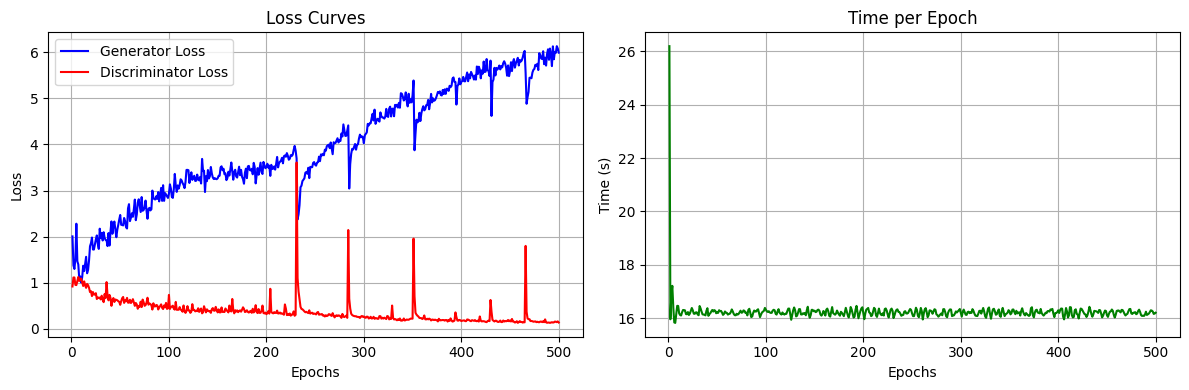

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load training metrics
metrics_path = os.path.join(Config.LOG_DIR, 'training_metrics.json')
if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"Metrics not found at: {metrics_path}")

with open(metrics_path, 'r') as f:
    metrics = json.load(f)

# Plot loss curves
epochs = metrics['epochs']
g_loss = metrics['generator_loss']
d_loss = metrics['discriminator_loss']
epoch_times = metrics['batch_times']

plt.figure(figsize=(12, 4))

# Generator vs Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, g_loss, label='Generator Loss', color='blue')
plt.plot(epochs, d_loss, label='Discriminator Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

# Epoch time
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_times, color='green')
plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.title("Time per Epoch")
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'evaluation_training_curves.png'), dpi=150)
plt.show()


✅ Generator loaded successfully!


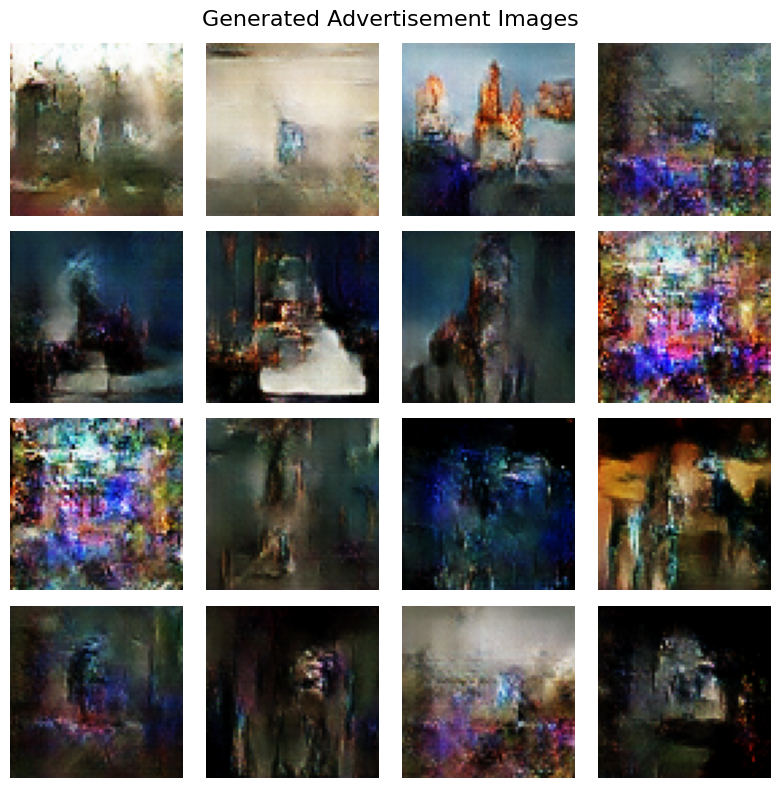

In [4]:
# Load the trained generator model
generator_path = os.path.join(Config.OUTPUT_DIR, 'generator_model.keras')

if os.path.exists(generator_path):
    generator = tf.keras.models.load_model(generator_path)
    print("✅ Generator loaded successfully!")
else:
    raise FileNotFoundError("❌ Trained generator model not found. Please run training first.")

# Generate new images
num_images = 16
noise = tf.random.normal([num_images, Config.NOISE_DIM])
generated_images = generator(noise, training=False)

# Plot generated images
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(4, 4, i+1)
    if Config.CHANNELS == 1:
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    else:
        plt.imshow((generated_images[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8))
    plt.axis('off')

plt.suptitle("Generated Advertisement Images", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'new_generated_ads.png'), dpi=150)
plt.show()
